In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import warnings
from typing import Self
from datetime import datetime
from functools import reduce
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from concurrent.futures import ThreadPoolExecutor, wait, FIRST_COMPLETED

import src.utils.anomalydetectors as m
import src.utils.globals as g
import src.utils.aggregators as agg

from src.utils.noise import NoiseFactory
from src.utils.plotting import plot_rpcurves
from src.utils.experiment import Experiment


In [2]:
def run_experiment(df : pd.DataFrame, models, columns, name, synanomalies=True):
    if synanomalies:
        df['anomalous'] = df['anomaly_syn_type'] != ""
    else:
        df['anomalous'] = df['anomaly'] != "none"


    df_anomalies = df.groupby('seqid').agg({'anomalous' : any})

    experiment = Experiment(name)
    experiment.run(df, models, (['seqid', 'timeindex_bin'], columns), verbose=True)
    experiment.set_input(df)
    experiment.set_anomalies(df_anomalies)
    experiment.calculate_metrics(models=models, aggrfunc=agg.aggr_sum)

    experiment.pickle()

    return experiment

def name_none_experiment():
    return "nonoise"

def name_gaussian_experiment(ratio, intensity):
    return f"gaussian_{ratio}_{intensity}"

def name_sinusoidal_experiment(ratio, intensity):
    return f"sinus_{ratio}_{intensity}"

def name_point_experiment(ratio, intensity):
    return f"point_{ratio}_{intensity}"

def run_gaussian_experiment(df : pd.DataFrame, models, exp_columns, syn_column, ratio, intensity):
    name = name_gaussian_experiment(ratio, intensity)
    df_syn = NoiseFactory.gaussian(df, syn_column, ratio, intensity)
    return run_experiment(df_syn, models, exp_columns, name)

def run_sinusoidal_experiment(df : pd.DataFrame, models, exp_columns, syn_column, ratio, intensity):
    name = name_sinusoidal_experiment(ratio, intensity)
    df_syn = NoiseFactory.sinusoidal(df, syn_column, ratio, intensity)
    return run_experiment(df_syn, models, exp_columns, name)

def run_point_experiment(df : pd.DataFrame, models, exp_columns, syn_column, ratio, intensity):
    name = name_point_experiment(ratio, intensity)
    df_syn = NoiseFactory.point(df, syn_column, ratio, intensity)
    return run_experiment(df_syn, models, exp_columns, name)

def run__none_experiment(df : pd.DataFrame, models, exp_columns):
    name = name_none_experiment()
    return run_experiment(df, models, exp_columns, name, synanomalies=False)


In [3]:
df_in = pd.read_parquet(g.path_imu)
#df_in['timeindex'] = df_in['timeindex'] / df_in['timeindex'].max()

# Experiment Constants

In [4]:
# Boolean whether to run the experiments or load
load_experiments = True

# Running Experiment Parameters
models = [m.ZScore(), m.MZScore(), m.LOF(), m.IF()]
exp_columns = [f'acceleration_{x}' for x in ['x', 'y', 'z']]
syn_column = 'acceleration_x'

guassian_params     = [0.10, 0.25, 0.40, 0.55]
sinusoidal_params   = [0.25, 0.5, 1, 2]
point_params        = [1, 5, 10, 100]

synratio = 0.1

# Loading Experiment Parameters



# GAUSSIAN

In [5]:
exps_gaussian = {}
if load_experiments:
    for intensity in guassian_params:
        name = name_gaussian_experiment(synratio, intensity)
        print(f"Loading {name}")
        exps_gaussian[name] = Experiment.unpickle(name)
    print("Loading Experiments Done")
else:
    for intensity in guassian_params:
        print(f"Running Experiment gaussian {intensity}")
        exp = run_gaussian_experiment(df_in, models, exp_columns, exp_columns[0], ratio=synratio, intensity=intensity)
        exps_gaussian[exp.name] = exp
    print("Running Experiments Done")
    

Loading gaussian_0.1_0.1
Loading gaussian_0.1_0.25
Loading gaussian_0.1_0.4
Loading gaussian_0.1_0.55
Loading Experiments Done


In [ ]:
rp_curves = {}
for exp in models:
    mname = exp.name
    rp_curves[mname] = {}
    for (ename, exp) in exps_gaussian.items():
        rp_curves[mname][ename] = exp.results['pr'][mname]
    with warnings.catch_warnings(action="ignore"):
        plot_rpcurves(rp_curves[mname], colnums=4, title=mname, auc=True, f1=False, showtitle=False)

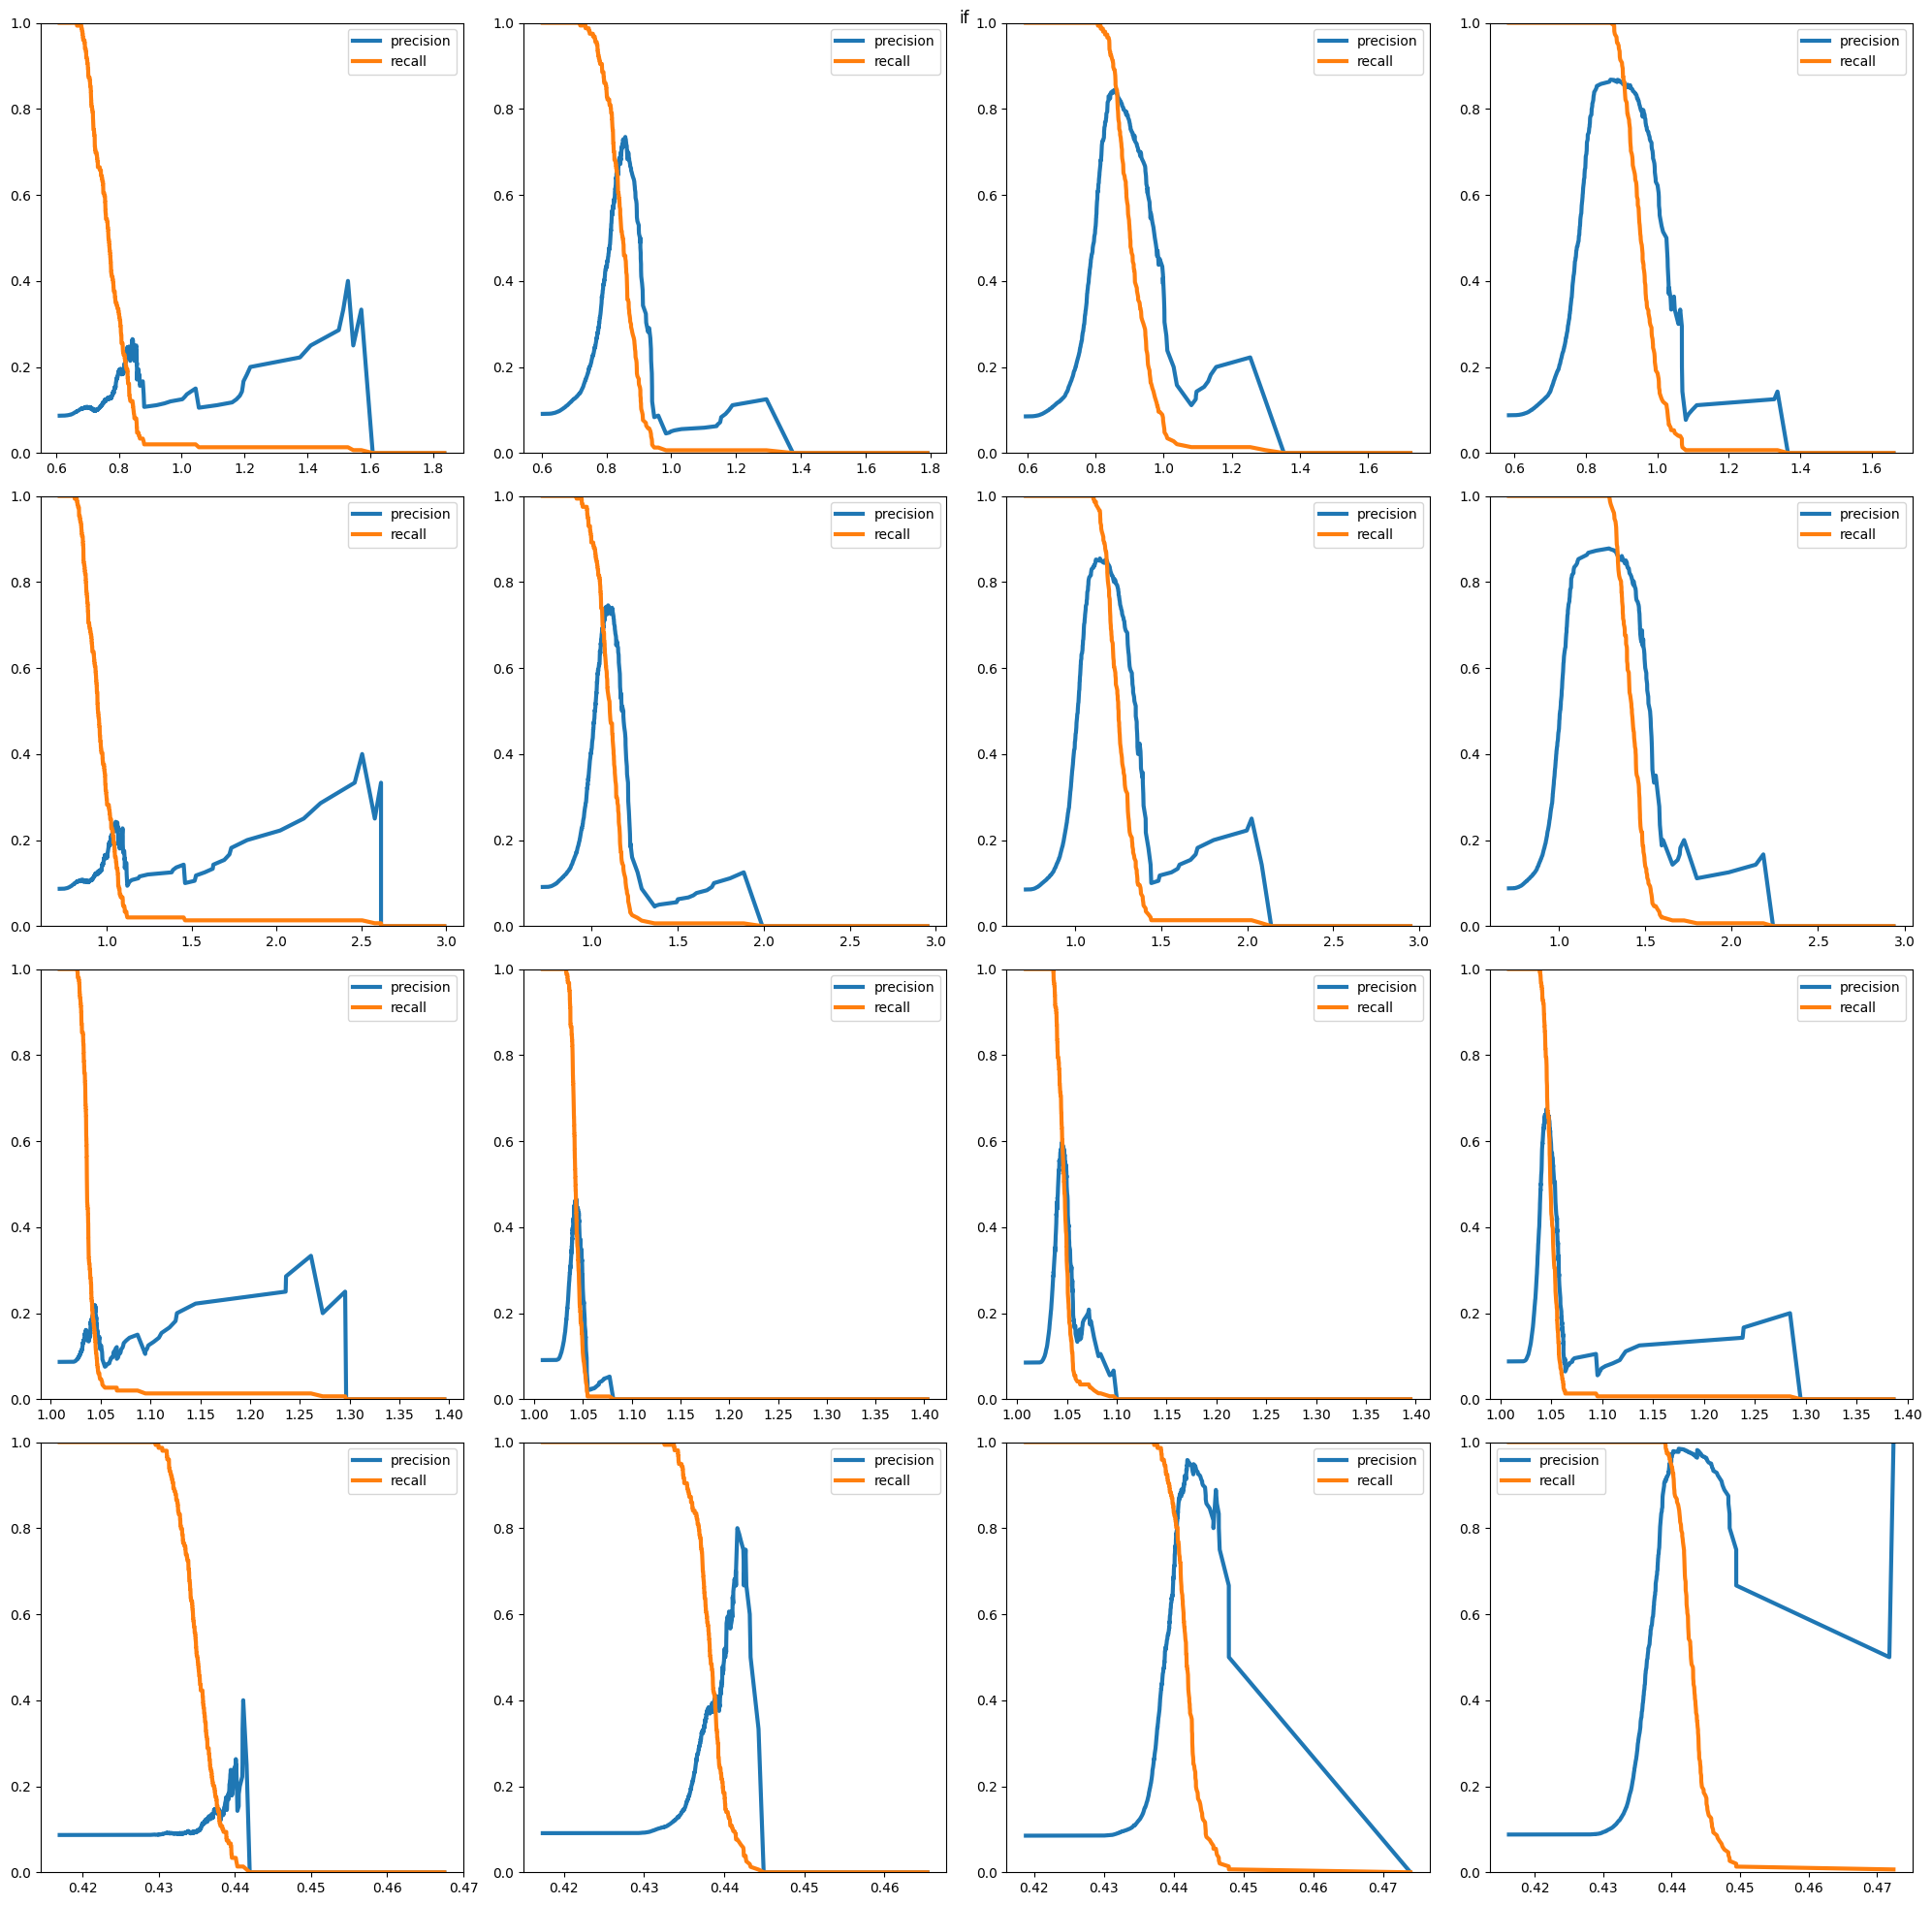

In [6]:
rp_curves = {}
for exp in models:
    mname = exp.name
    for (ename, exp) in exps_gaussian.items():
        rp_curves[f"{mname}_{ename}"] = exp.results['pr'][mname]


with warnings.catch_warnings(action="ignore"):
    plot_rpcurves(rp_curves, colnums=4, title=mname, auc=True, f1=False, showtitle=False)

In [ ]:
def plot_acceleration(df, seqid):
    df_seqid = df[df['seqid'] == seqid]

    plt.figure(figsize=(12, 6))
    plt.plot(df_seqid['timeindex'], df_seqid['acceleration_x'], label='Acceleration X')
    plt.plot(df_seqid['timeindex'], df_seqid['acceleration_y'], label='Acceleration Y')
    plt.plot(df_seqid['timeindex'], df_seqid['acceleration_z'], label='Acceleration Z')
    plt.xlabel('Time Index')
    plt.ylabel('Acceleration')
    plt.title(f'Acceleration Data for seqid: {seqid}')
    plt.legend()
    plt.show()


tmpdf = list(exps_gaussian.items())[0][1].results['input']
seqid = "2024.09.16|04.21.37|original"
plot_acceleration(tmpdf, seqid)


# SINUSOIDAL

In [7]:
exps_sinusoidal = {}
if load_experiments:
    for intensity in sinusoidal_params:
        name = name_sinusoidal_experiment(synratio, intensity)
        print(f"Loading {name}")
        exps_sinusoidal[name] = Experiment.unpickle(name)
    print("Loading Experiments Done")
else:
    for intensity in sinusoidal_params:
        print(f"Running Experiment Sinusoidal {intensity}")
        exp = run_sinusoidal_experiment(df_in, models, exp_columns, exp_columns[0], ratio=synratio, intensity=intensity)
        exps_sinusoidal[exp.name] = exp
    print("Running Experiments Done")
    

Loading sinus_0.1_0.25
Loading sinus_0.1_0.5
Loading sinus_0.1_1
Loading sinus_0.1_2
Loading Experiments Done


In [ ]:
rp_curves = {}
for exp in models:
    mname = exp.name
    rp_curves[mname] = {}
    for (ename, exp) in exps_sinusoidal.items():
        rp_curves[mname][ename] = exp.results['pr'][mname]
    with warnings.catch_warnings(action="ignore"):
        plot_rpcurves(rp_curves[mname], colnums=4, title=mname, auc=True, f1=False, showtitle=False)
        

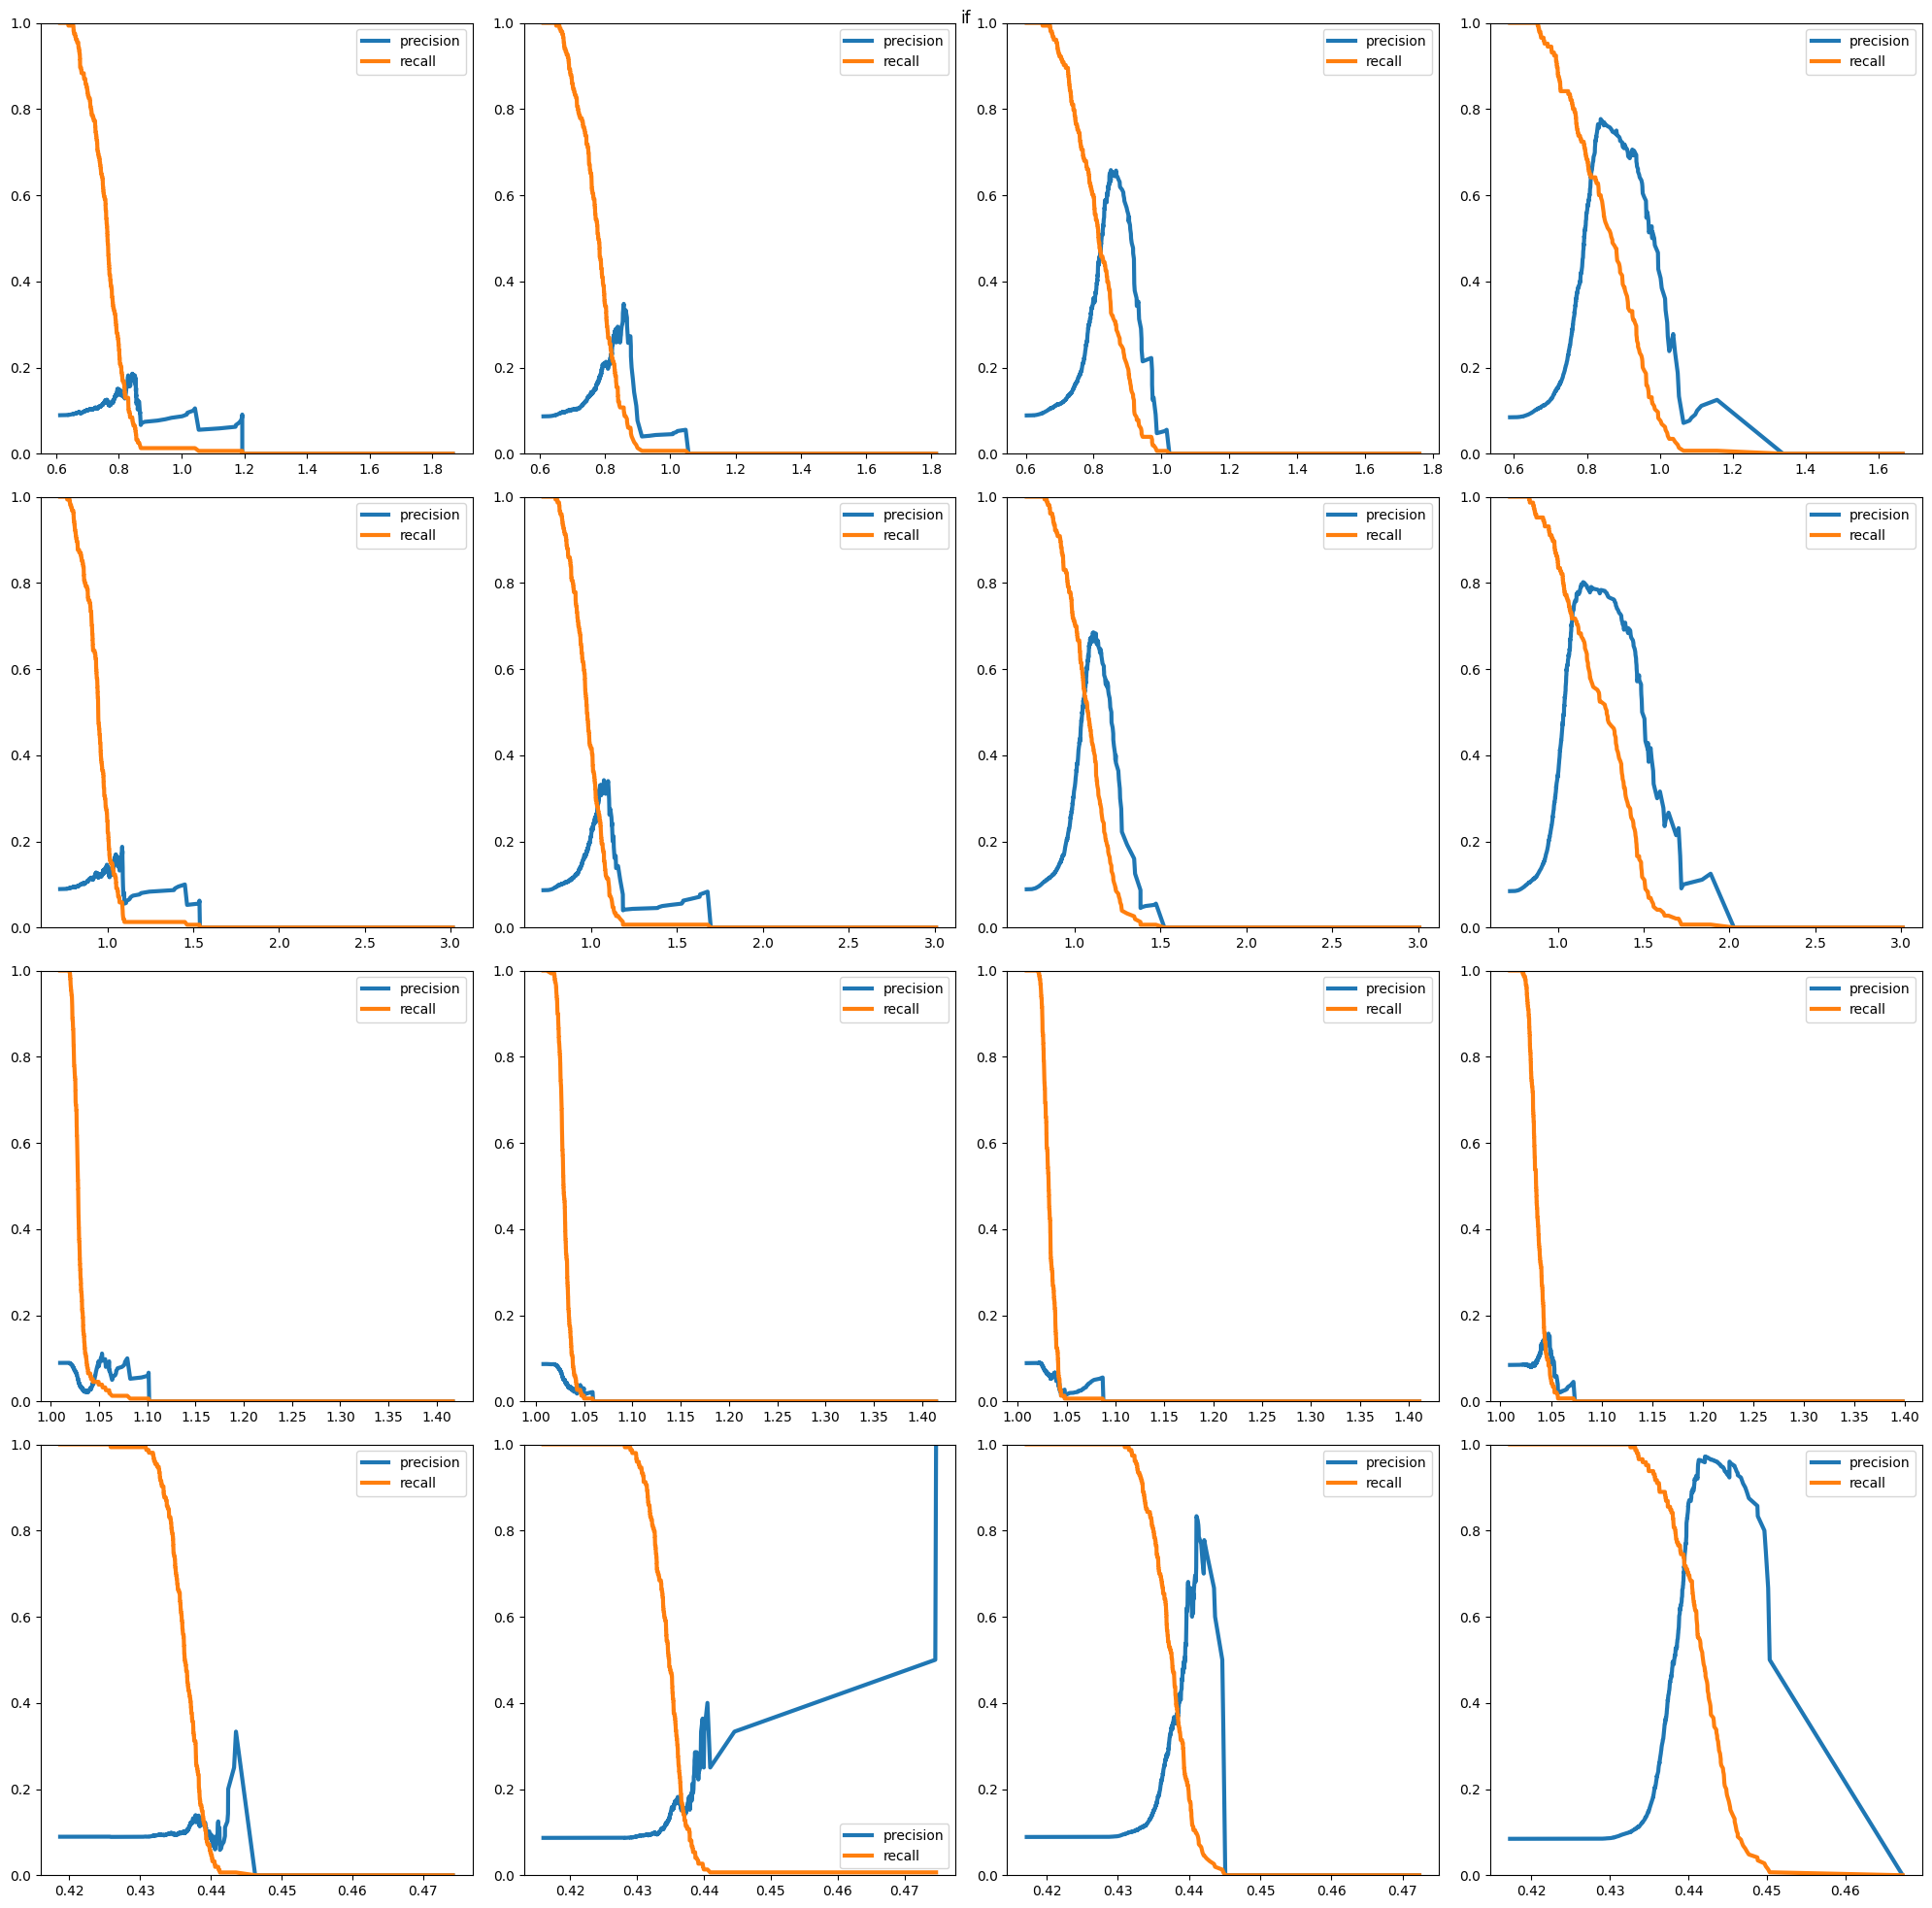

In [8]:
rp_curves = {}
for exp in models:
    mname = exp.name
    for (ename, exp) in exps_sinusoidal.items():
        rp_curves[f"{mname}_{ename}"] = exp.results['pr'][mname]


with warnings.catch_warnings(action="ignore"):
    plot_rpcurves(rp_curves, colnums=4, title=mname, auc=True, f1=False, showtitle=False)

# POINT

In [9]:
exps_point = {}
if load_experiments:
    for intensity in point_params:
        name = name_point_experiment(synratio, intensity)
        print(f"Loading {name}")
        exps_point[name] = Experiment.unpickle(name)
    print("Loading Experiments Done")
else:
    for intensity in point_params:
        print(f"Running Experiment Point {intensity}")
        exp = run_point_experiment(df_in, models, exp_columns, exp_columns[0], ratio=synratio, intensity=intensity)
        exps_point[exp.name] = exp
    print("Running Experiments Done")
    

Loading point_0.1_1
Loading point_0.1_5
Loading point_0.1_10
Loading point_0.1_100
Loading Experiments Done


In [ ]:
rp_curves = {}
for exp in models:
    mname = exp.name
    rp_curves[mname] = {}
    for (ename, exp) in exps_point.items():
        rp_curves[mname][ename] = exp.results['pr'][mname]
    with warnings.catch_warnings(action="ignore"):
        plot_rpcurves(rp_curves[mname], colnums=4, title=mname, auc=True, f1=False, showtitle=False)
        

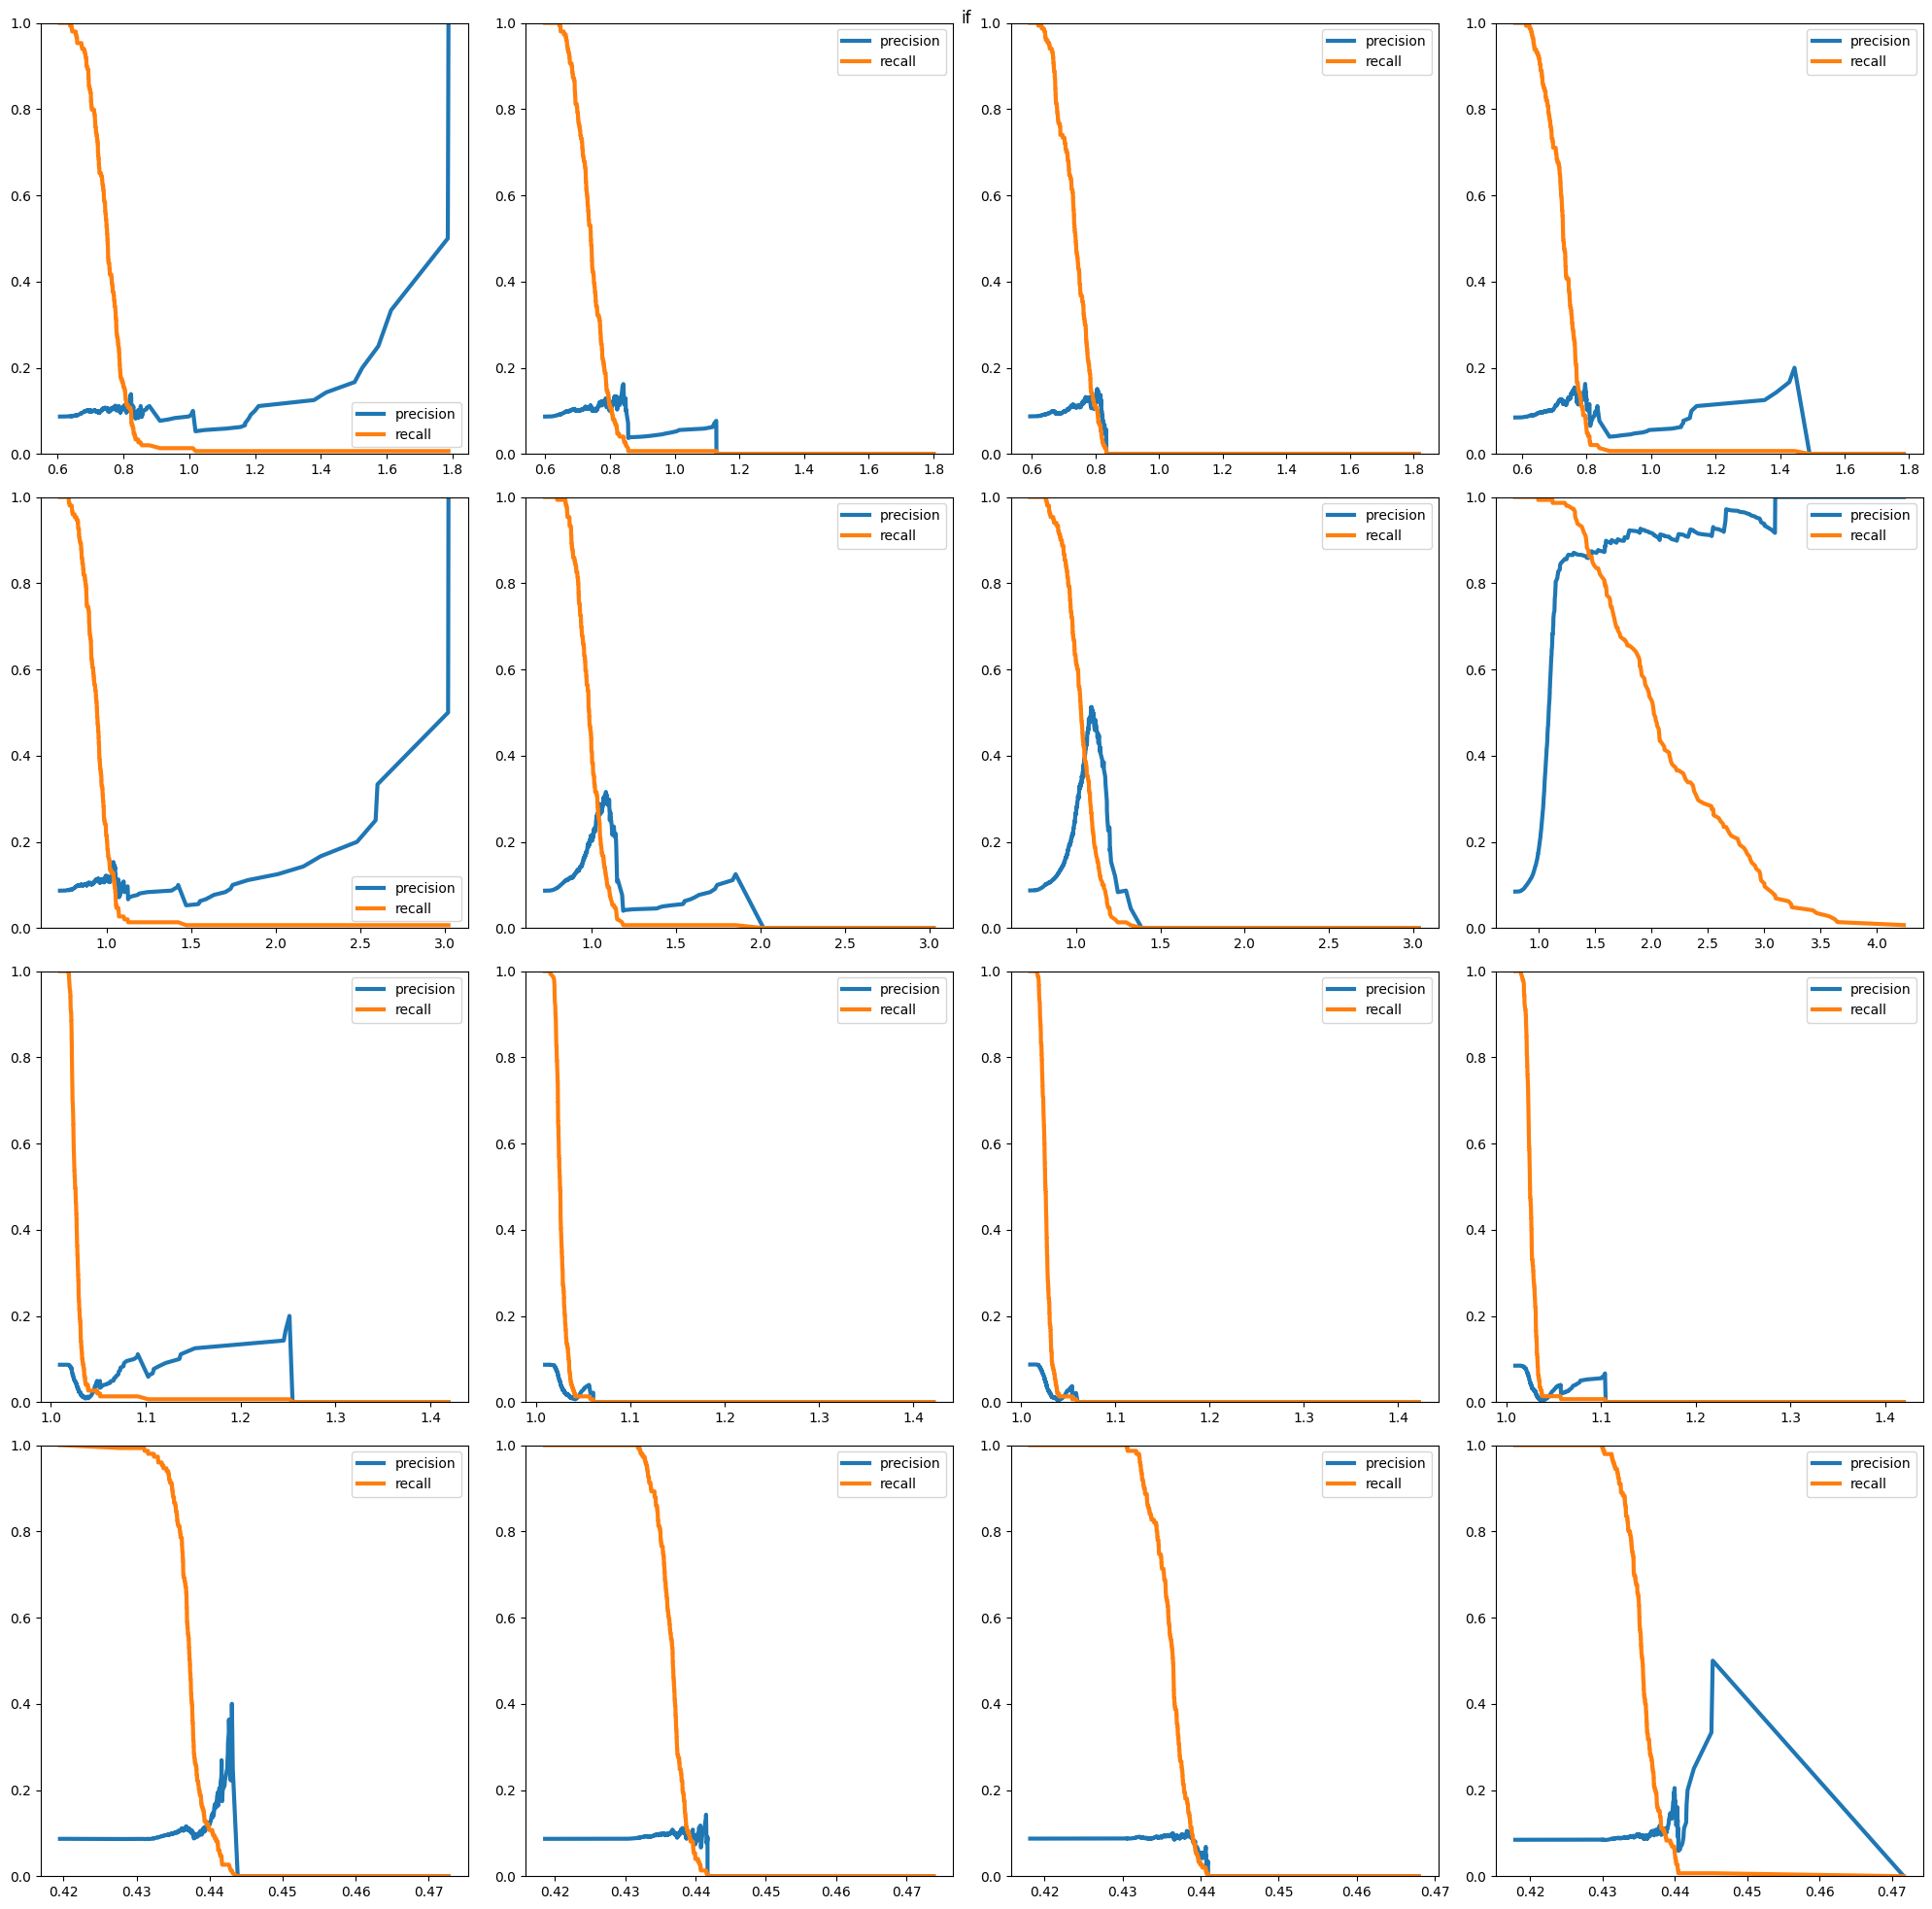

In [10]:
rp_curves = {}
for exp in models:
    mname = exp.name
    for (ename, exp) in exps_point.items():
        rp_curves[f"{mname}_{ename}"] = exp.results['pr'][mname]


with warnings.catch_warnings(action="ignore"):
    plot_rpcurves(rp_curves, colnums=4, title=mname, auc=True, f1=False, showtitle=False)

# Normal Anomalies

In [ ]:
# anomalies = ['tiled-right', 'tiled-left', 'screwdriver', 'floor-bubbles', 'nosupport-right']
# df_in['anomaly'].value_counts()

anomaly
none               4460918
tiled-right         127703
tiled-left          127696
tilted-left          79536
screwdriver          63729
floor-bubbles        63647
tilted-right         63605
nosupport-right       9550
Name: count, dtype: int64

In [5]:
exps_none = {}
if load_experiments:
    name = name_none_experiment()
    print(f"Loading {name}")
    exps_none[name] = Experiment.unpickle(name)
    print("Loading Experiments Done")
else:
    print(f"Running Experiment Point {intensity}")
    exp = run__none_experiment(df_in, models, exp_columns)
    exps_none[exp.name] = exp
    print("Running Experiments Done")

Loading nonoise
Loading Experiments Done


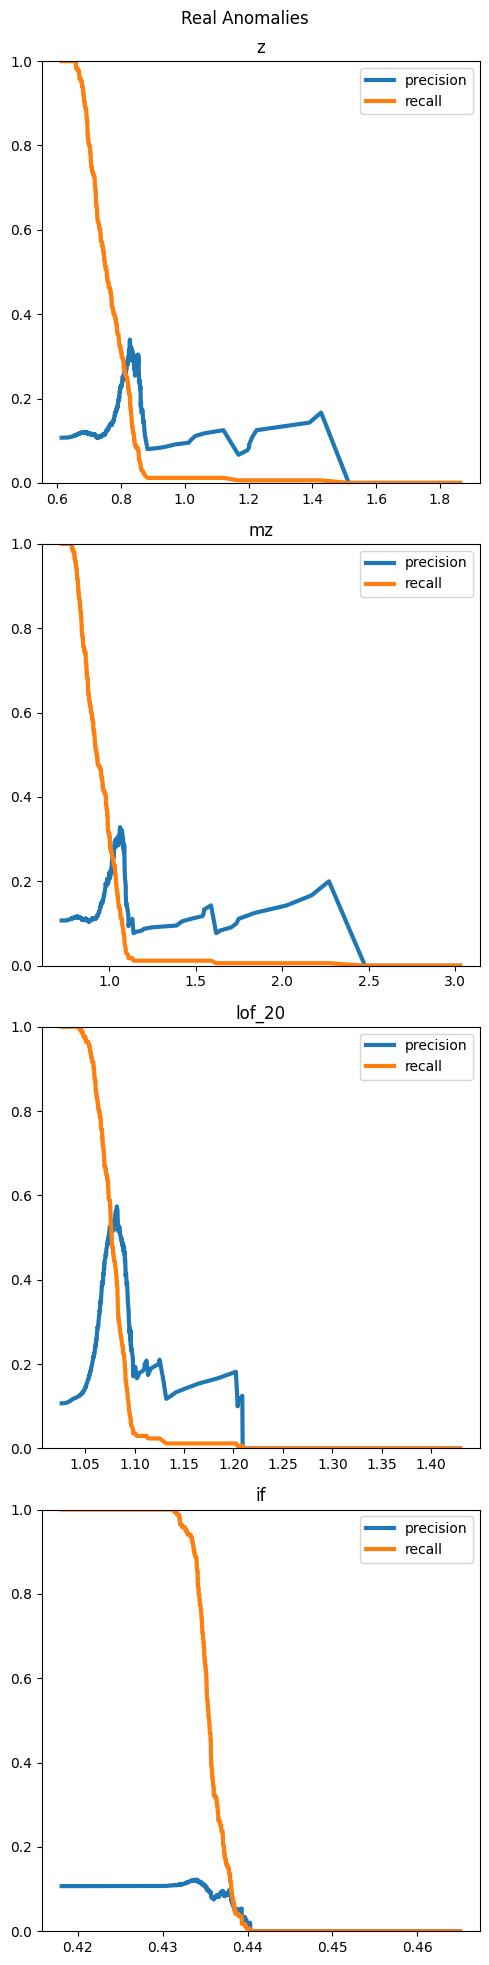

In [6]:
rp_curves = {}
for exp in models:
    mname = exp.name
    rp_curves[mname] = {}
    for (ename, exp) in exps_none.items():
        rp_curves[mname] = exp.results['pr'][mname]
with warnings.catch_warnings(action="ignore"):
    plot_rpcurves(rp_curves, colnums=1, title="Real Anomalies\n", auc=False, f1=False, showtitle=True)